In [1]:
import cv2 as cv
import numpy as np
from matplotlib import pyplot as plt
from skimage import img_as_ubyte

from skimage.measure import compare_ssim

In [2]:
originalImage = cv.imread('PenguinOriginal.bmp',0)
noisyImage = cv.imread('PenguinNoise.bmp',0)

## Average Mean Squared Error

In [3]:
def amse(A, B):
    error = np.sum((A.astype("float") - B.astype("float")) ** 2)
    error /= float(A.shape[0] * A.shape[1])
    return error

# Exercise 1

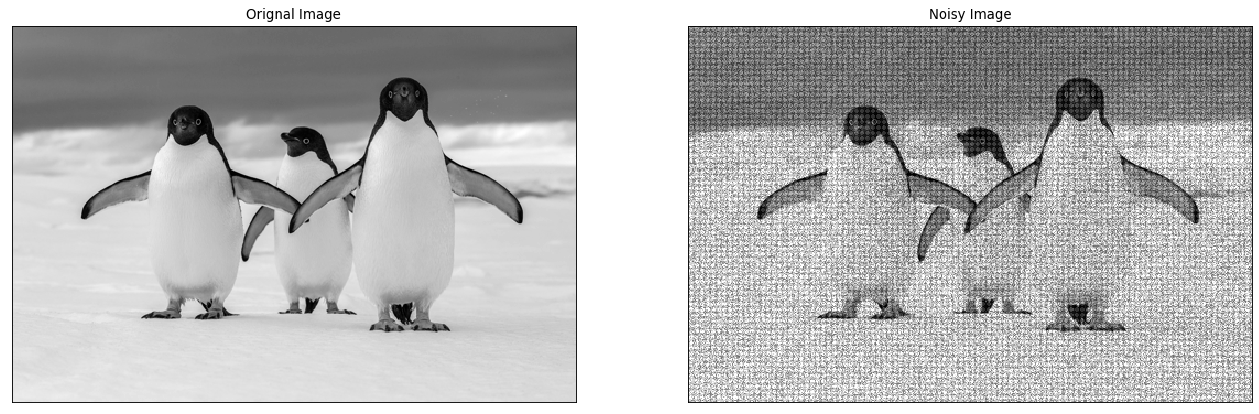

In [4]:
fig = plt.figure(figsize = (20, 35), dpi = 80, facecolor = 'w', edgecolor = 'k')
plt.subplot(121),plt.imshow(originalImage, cmap = 'gray')
plt.title('Orignal Image'), plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(noisyImage, cmap = 'gray')
plt.title('Noisy Image'), plt.xticks([]), plt.yticks([])
plt.show()

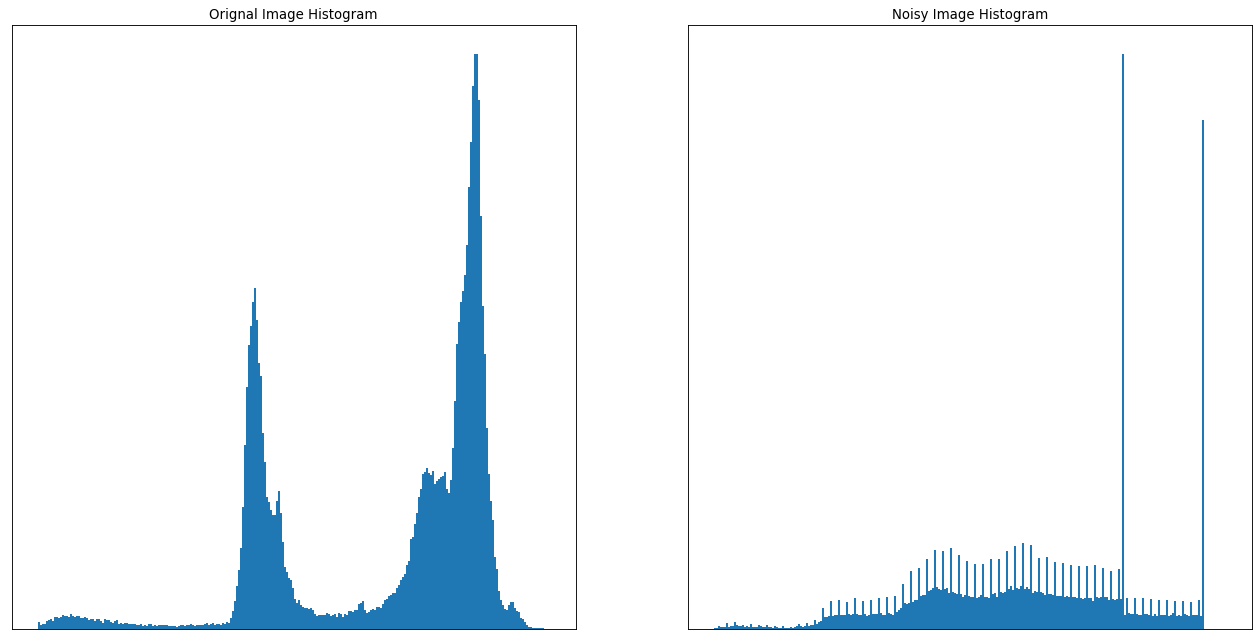

In [5]:
fig = plt.figure(figsize = (20, 10), dpi = 80, facecolor = 'w', edgecolor = 'k')
plt.subplot(121),plt.hist(originalImage.ravel(),256,[0,256])
plt.title('Orignal Image Histogram'), plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.hist(noisyImage.ravel(), 256, [0,256])
plt.title('Noisy Image Histogram'), plt.xticks([]), plt.yticks([])
plt.show()

## Frequency Domain

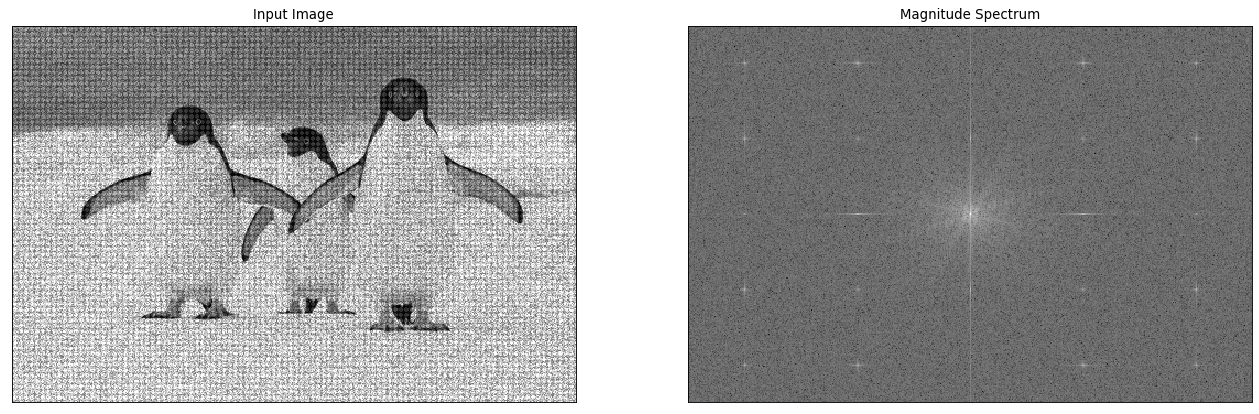

In [6]:
dft = cv.dft(np.float32(noisyImage),flags = cv.DFT_COMPLEX_OUTPUT)
dft_shift = np.fft.fftshift(dft)
magnitude_spectrum = 20*np.log(cv.magnitude(dft_shift[:,:,0],dft_shift[:,:,1]))
fig = plt.figure(figsize = (20, 35), dpi = 80, facecolor = 'w', edgecolor = 'k')
plt.subplot(121),plt.imshow(noisyImage, cmap = 'gray')
plt.title('Input Image'), plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(magnitude_spectrum, cmap = 'gray')
plt.title('Magnitude Spectrum'), plt.xticks([]), plt.yticks([])
plt.show()

### Low Pass filter

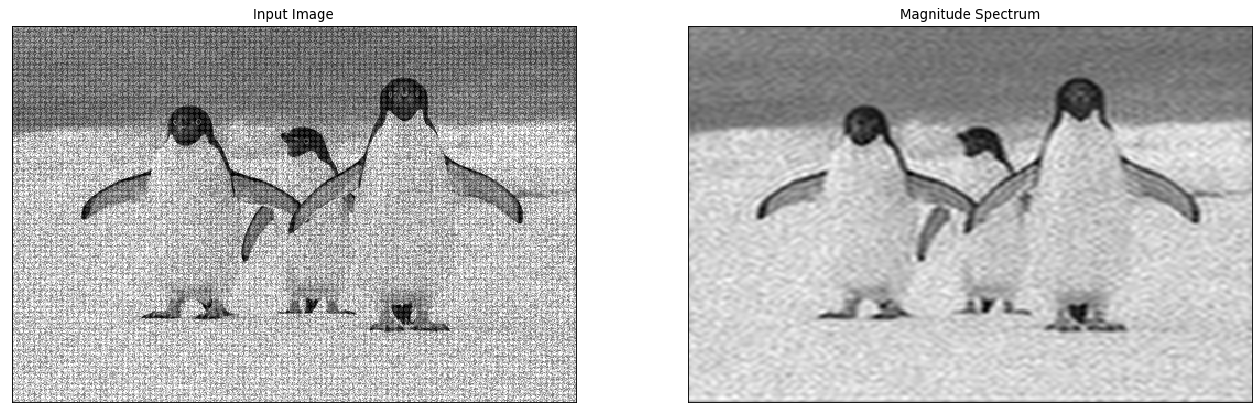

In [7]:
rows, cols = noisyImage.shape
crow, ccol = int(rows/2), int(cols/2)

maskDim = 55 #USE THIS SAM

# create a mask first, center square is 1, remaining all zeros
mask = np.zeros((rows,cols,2),np.uint8)
mask[crow-maskDim:crow+maskDim, ccol-maskDim:ccol+maskDim] = 1

# apply mask and inverse DFT
fshift = dft_shift*mask
f_ishift = np.fft.ifftshift(fshift)
intermediateImage = cv.idft(f_ishift)
intermediateImage = cv.magnitude(intermediateImage[:,:,0],intermediateImage[:,:,1])

fig = plt.figure(figsize = (20, 35), dpi = 80, facecolor = 'w', edgecolor = 'k')
plt.subplot(121),plt.imshow(noisyImage, cmap = 'gray')
plt.title('Input Image'), plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(intermediateImage, cmap = 'gray')
plt.title('Magnitude Spectrum'), plt.xticks([]), plt.yticks([])
plt.show()

In [8]:
intermediateImage = cv.normalize(intermediateImage,None,0,255,cv.NORM_MINMAX,cv.CV_8U)

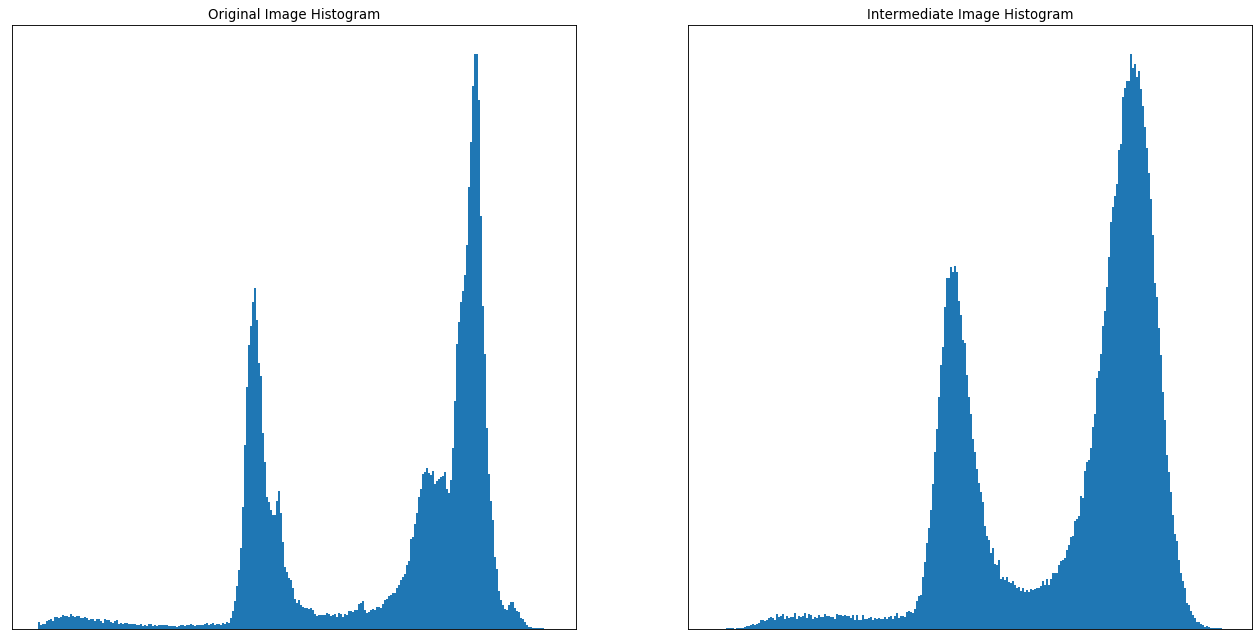

In [9]:
fig = plt.figure(figsize = (20, 10), dpi = 80, facecolor = 'w', edgecolor = 'k')
plt.subplot(121),plt.hist(originalImage.ravel(),256,[0,256])
plt.title('Original Image Histogram'), plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.hist(intermediateImage.ravel(), 256, [0,256])
plt.title('Intermediate Image Histogram'), plt.xticks([]), plt.yticks([])
plt.show()

### High Pass Filter

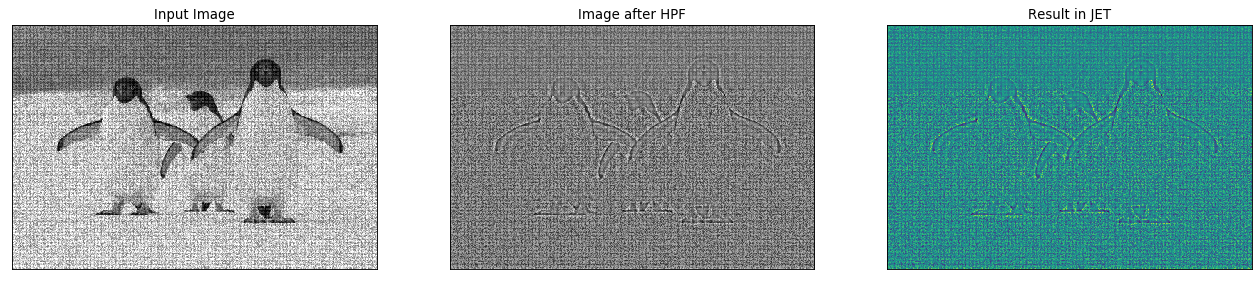

In [10]:
f = np.fft.fft2(noisyImage)
fshift = np.fft.fftshift(f)
magnitude_spectrum = 20*np.log(np.abs(fshift))

rows, cols = noisyImage.shape
crow,ccol = rows//2 , cols//2
fshift[crow-30:crow+31, ccol-30:ccol+31] = 0
f_ishift = np.fft.ifftshift(fshift)
img_back = np.fft.ifft2(f_ishift)
img_back = np.real(img_back)

fig = plt.figure(figsize = (20, 35), dpi = 80, facecolor = 'w', edgecolor = 'k')
plt.subplot(131),plt.imshow(noisyImage, cmap = 'gray')
plt.title('Input Image'), plt.xticks([]), plt.yticks([])
plt.subplot(132),plt.imshow(img_back, cmap = 'gray')
plt.title('Image after HPF'), plt.xticks([]), plt.yticks([])
plt.subplot(133),plt.imshow(img_back)
plt.title('Result in JET'), plt.xticks([]), plt.yticks([])
plt.show()

## Spatial Domain

### Median Filtering

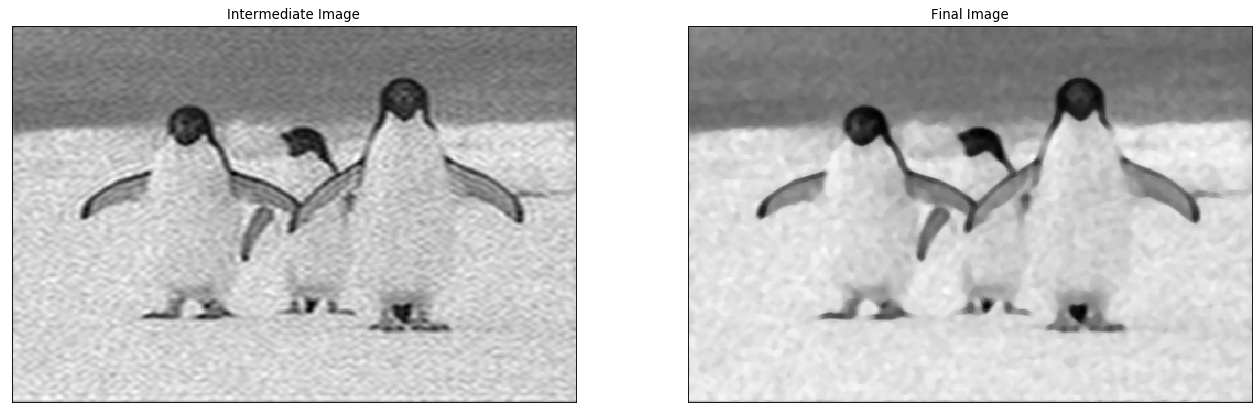

True

In [11]:
finalImage = cv.medianBlur(intermediateImage, 7)

fig = plt.figure(figsize = (20, 35), dpi = 80, facecolor = 'w', edgecolor = 'k')
plt.subplot(121),plt.imshow(intermediateImage, cmap = 'gray')
plt.title('Intermediate Image'), plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(finalImage, cmap = 'gray')
plt.title('Final Image'), plt.xticks([]), plt.yticks([])
plt.show()

cv.imwrite("PenguinFinal.bmp", finalImage)

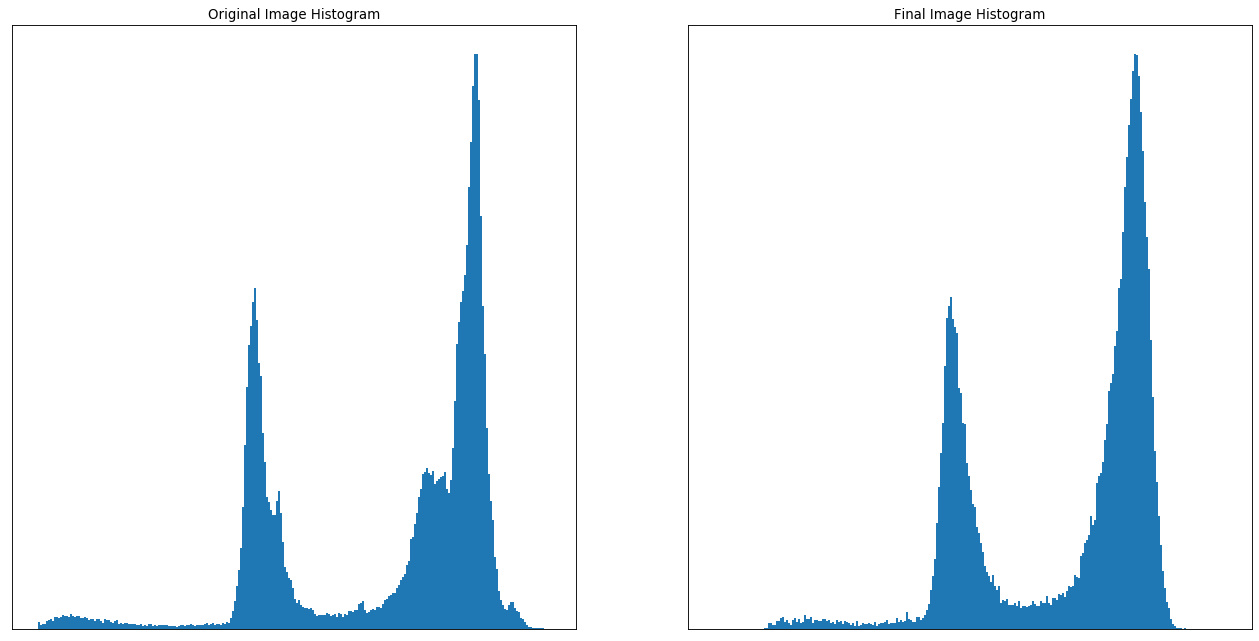

In [12]:
fig = plt.figure(figsize = (20, 10), dpi = 80, facecolor = 'w', edgecolor = 'k')
plt.subplot(121),plt.hist(originalImage.ravel(),256,[0,256])
plt.title('Original Image Histogram'), plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.hist(finalImage.ravel(), 256, [0,256])
plt.title('Final Image Histogram'), plt.xticks([]), plt.yticks([])
plt.show()

### Non-linear means filtering

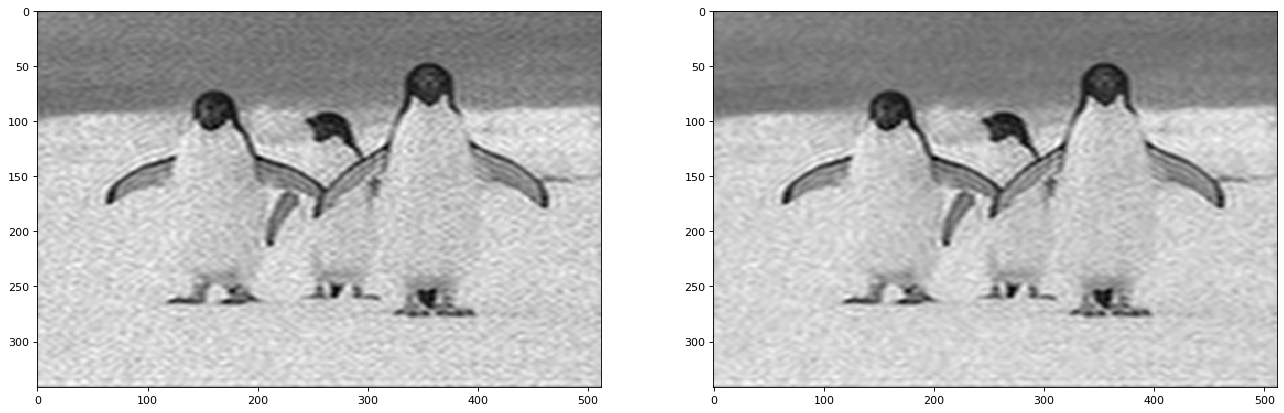

In [13]:
nlmeans = cv.fastNlMeansDenoising(intermediateImage,None,7,21,5)
fig = plt.figure(figsize = (20, 10), dpi = 80, facecolor = 'w', edgecolor = 'k')
plt.subplot(121),plt.imshow(intermediateImage, cmap = 'gray')
plt.subplot(122),plt.imshow(nlmeans, cmap = 'gray')
plt.show()

In [14]:
amse(originalImage, nlmeans)
compare_ssim(originalImage, nlmeans)

0.671372866635101

### 2D Convolution

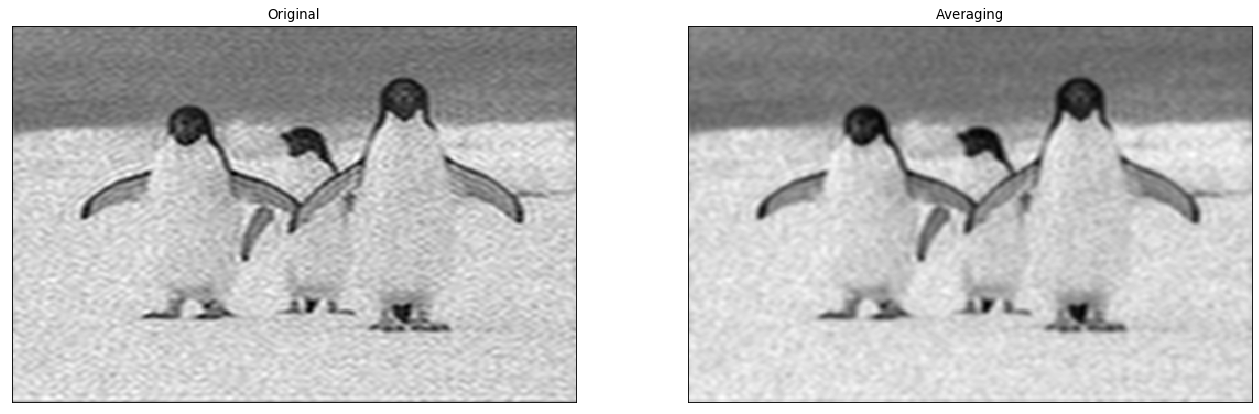

In [15]:
kernel = np.ones((5,5),np.float32)/25
conv = cv.filter2D(intermediateImage,-1,kernel)

fig = plt.figure(figsize = (20, 10), dpi = 80, facecolor = 'w', edgecolor = 'k')
plt.subplot(121),plt.imshow(intermediateImage,cmap = 'gray'),plt.title('Original')
plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(conv,cmap = 'gray'),plt.title('Averaging')
plt.xticks([]), plt.yticks([])
plt.show()

In [16]:
amse(originalImage, conv)
compare_ssim(originalImage, conv)

0.7432491894705404

### Averaging

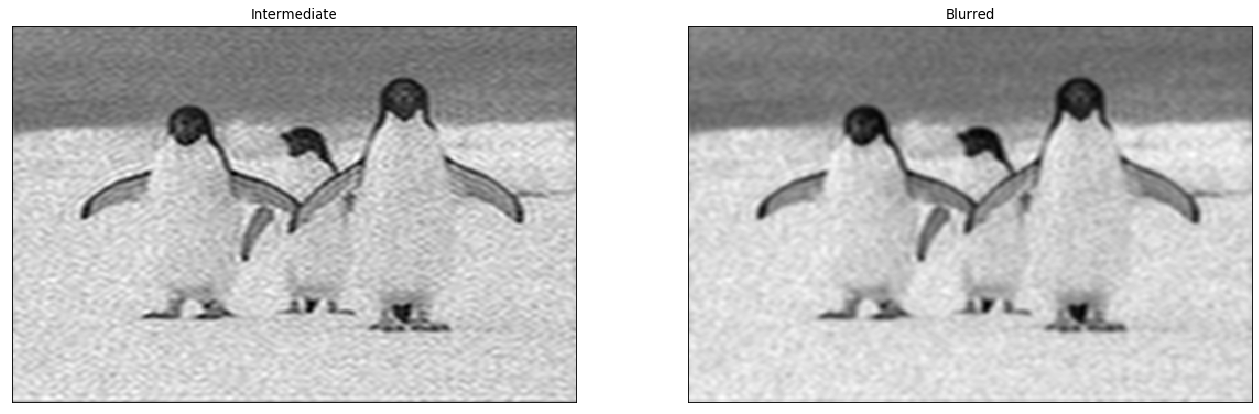

In [17]:
avg = cv.blur(intermediateImage,(5,5))

fig = plt.figure(figsize = (20, 10), dpi = 80, facecolor = 'w', edgecolor = 'k')
plt.subplot(121),plt.imshow(intermediateImage,cmap = 'gray'),plt.title('Intermediate')
plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(avg,cmap = 'gray'),plt.title('Blurred')
plt.xticks([]), plt.yticks([])
plt.show()

In [18]:
amse(originalImage, avg)
compare_ssim(originalImage, avg)

0.7432491894705404

### Gaussian Blurring

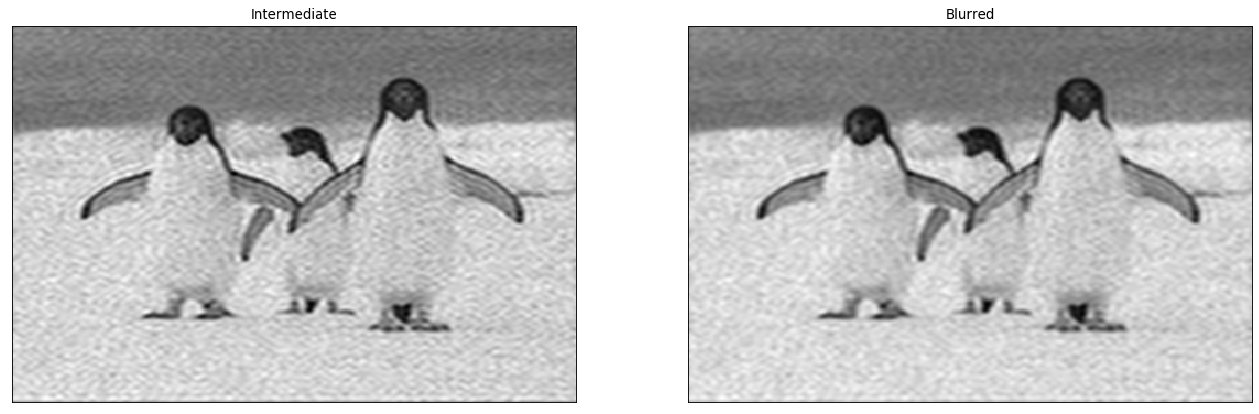

In [19]:
gauss = cv.GaussianBlur(intermediateImage,(5,5),0)
fig = plt.figure(figsize = (20, 10), dpi = 80, facecolor = 'w', edgecolor = 'k')
plt.subplot(121),plt.imshow(intermediateImage,cmap = 'gray'),plt.title('Intermediate')
plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(gauss,cmap = 'gray'),plt.title('Blurred')
plt.xticks([]), plt.yticks([])
plt.show()

In [20]:
amse(originalImage, gauss)
compare_ssim(originalImage, gauss)

0.6707122208251434

### Bilateral Filtering

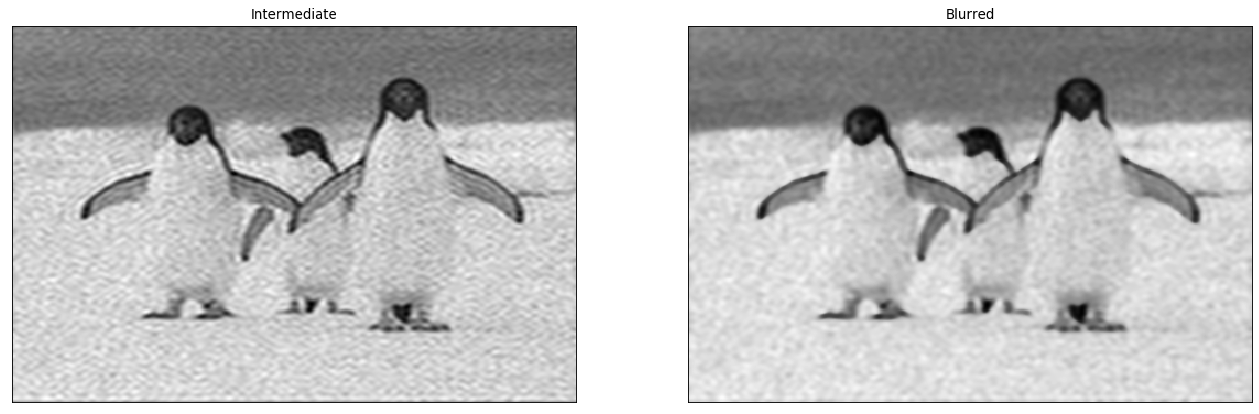

In [21]:
bilat = cv.bilateralFilter(intermediateImage,7,75,75)
fig = plt.figure(figsize = (20, 10), dpi = 80, facecolor = 'w', edgecolor = 'k')
plt.subplot(121),plt.imshow(intermediateImage,cmap = 'gray'),plt.title('Intermediate')
plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(bilat,cmap = 'gray'),plt.title('Blurred')
plt.xticks([]), plt.yticks([])
plt.show()

In [22]:
amse(originalImage, bilat)
compare_ssim(originalImage, bilat)

0.7640010276744672

Results for Exercise 1

In [23]:
print("AMSE for Original vs Original: {}\nAMSE for Original vs Noisy: {}\nAMSE for Original vs Intermediate: {}\nAMSE for Original vs Final: {}".format(amse(originalImage, originalImage), amse(originalImage, noisyImage), amse(originalImage, intermediateImage), amse(originalImage, finalImage)))

AMSE for Original vs Original: 0.0
AMSE for Original vs Noisy: 1731.1934450383771
AMSE for Original vs Intermediate: 218.1794761970029
AMSE for Original vs Final: 199.8361145376462


In [24]:
print("SSIM for Original vs Original: {}\nSSIM for Original vs Noisy: {}\nSSIM for Original vs Intermediate {}\nSSIM for Original vs Final: {}".format(compare_ssim(originalImage, originalImage), compare_ssim(originalImage, noisyImage),compare_ssim(originalImage, intermediateImage),compare_ssim(originalImage, finalImage)))

SSIM for Original vs Original: 1.0
SSIM for Original vs Noisy: 0.1300935471312696
SSIM for Original vs Intermediate 0.5767022211399965
SSIM for Original vs Final: 0.8023371061372798


As we can see the best result for the AMSE is a 0 when comparing the processed image to the original image. This is shown because the original compared to a copy of itself produces a AMSE of 0.0. So whilst we have reduced the AMSE from the noisy image, it is still incredibly high in comparison to a pixel perfect match. Obviously the number of pixels will impact this error, so a better measure for image quality would be the SSIM of the images. This compares the images in the luminence, contrast and structure domain to produce a similarity score in the range [0,1]. Performing this shows that 1 corresponds to an exact match of the two images being comparing the original image to itself. By then using this method to compare the original image to the final de-noised image, we find that final image is 80% similar to the original

## Final Comparison

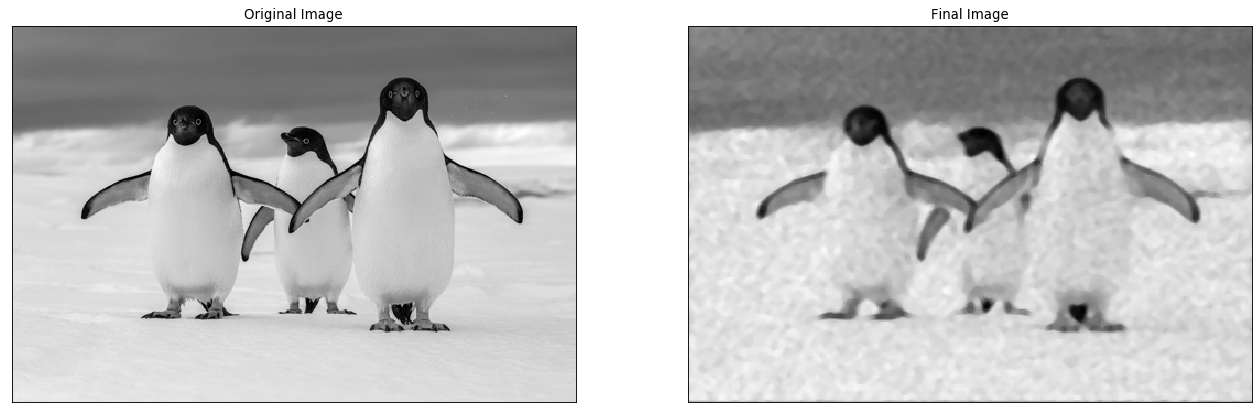

In [25]:
fig = plt.figure(figsize = (20, 35), dpi = 80, facecolor = 'w', edgecolor = 'k')
plt.subplot(121),plt.imshow(originalImage, cmap = 'gray')
plt.title('Original Image'), plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(finalImage, cmap = 'gray')
plt.title('Final Image'), plt.xticks([]), plt.yticks([])
plt.show()